In [1]:
import numpy as np
def parseMGF(mgfData):
    data = mgfData.read_text().split('\n')
    _comments = '#;!/'
    reading_spectrum = False
    params = {}
    masses = []
    intensities = []
    charges = []
    out = {}
    cnt = 0
    pep_mass = 0
    pep_intensity = 0
    out = {}
    for line in data:
        if not reading_spectrum:
            if line.strip() == 'BEGIN IONS': reading_spectrum = True
        else:
            if not line.strip() or any(line.startswith(c) for c in _comments): pass
            elif line.strip() == 'END IONS':
                reading_spectrum = False
                title = params['title'].split()[0]
                if 'pepmass' in params:
                    try:
                        pl = params['pepmass'].split()
                        if len(pl) > 1:
                            pep_mass = float(pl[0])
                            pep_intensity = float(pl[1])
                        elif len(pl) == 1: pep_mass = float(pl[0])
                    except ValueError: print("Error in parsing pepmass value")
                out[cnt] = {'pep_mass': pep_mass,'pep_intensity': pep_intensity,'rtinseconds': params['rtinseconds'],'title': params['title'],'charge': params['charge'],'mz_array': np.array(masses),'intensity_array': np.array(intensities)}
                cnt += 1
            else:
                l = line.split('=', 1)
                if len(l) > 1: params[l[0].lower()] = l[1].strip()
                elif len(l) == 1:  # looks like a peak list ;)
                    l = line.split()
                    if len(l) >= 2000:
                        try:
                            masses.append(float(l[0]))
                            intensities.append(float(l[1]))
                        except ValueError:
                            print("Error in parsing line "+line)
    return out

In [2]:
!pwd

/mnt/f/GD/notebooks


In [3]:
import pathlib
#file = pathlib.Path.cwd().parent.rglob('*.MGF')
file = pathlib.Path('/mnt/f/mgf/20150512_BSA_The-PEG-envelope.mgf')
#file = pathlib.Path.home()/'mgf' / '190128_robin_ 6' / '190128_robin_WT_5.mgf'
print(file.exists())#read_text().split(' '))
out=parseMGF(file)

True


In [4]:
X=[(out[k]['pep_mass']-1.00727647)*int(out[k]['charge'].split('+')[0]) for k, _ in out.items()]
X_mz1=np.array(X).reshape(-1, 1)
print(X_mz1.shape)

(7831, 1)


In [5]:
X=[(out[k]['pep_intensity']) for k, _ in out.items()]
X_int=np.array(X).reshape(-1, 1)
print(X_int.shape)

(7831, 1)


In [6]:
X=[np.float(out[k]['rtinseconds']) for k, _ in out.items()]
X_rt=np.array(X).reshape(-1, 1)
print(X_rt.shape)

(7831, 1)


In [7]:
k=0
print(out[k],X_int[k],X_mz1[k],X_rt[k])

{'pep_mass': 923.591193157233, 'pep_intensity': 597487.125, 'rtinseconds': '1.049124', 'title': '20150512_BSA_The-PEG-envelope.4.4.2 File:"20150512_BSA_The-PEG-envelope.raw", NativeID:"controllerType=0 controllerNumber=1 scan=4"', 'charge': '2+', 'mz_array': array([], dtype=float64), 'intensity_array': array([], dtype=float64)} [597487.125] [1845.16783337] [1.049124]


In [8]:
import matplotlib.pyplot as plt
#plt.hist(X_rt)
#plt.hist(np.log2(X_mz1))
#plt.scatter(X_mz1, int(X_rt))
print(X_mz1, X_rt)

[[1845.16783337]
 [1669.06151796]
 [1757.12071963]
 ...
 [1230.82837932]
 [ 912.55029029]
 [ 868.52364864]] [[1.04912400e+00]
 [1.14588300e+00]
 [1.24253400e+00]
 ...
 [3.29942946e+03]
 [3.29980968e+03]
 [3.30019752e+03]]


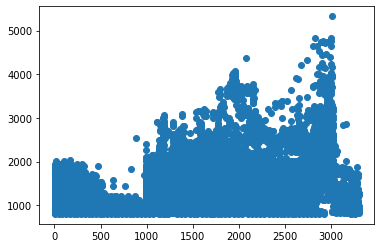

In [22]:
import matplotlib.pyplot as plt
#plt.hist(X_rt)
#plt.hist(np.log2(X_mz1))
plt.scatter(X_rt,X_mz1)#,X_int)
#plt.scatter(X_rt,X_int)

In [24]:
v=list(zip(X_rt.transpose(),X_mz1.transpose(),np.log2(X_int.transpose())))
v

[(array([1.04912400e+00, 1.14588300e+00, 1.24253400e+00, ...,
         3.29942946e+03, 3.29980968e+03, 3.30019752e+03]),
  array([1845.16783337, 1669.06151796, 1757.12071963, ..., 1230.82837932,
          912.55029029,  868.52364864]),
  array([19.1885481 , 20.08029414, 19.60656855, ..., 21.78528283,
         24.60777921, 23.82216468]))]

In [26]:
import ipyvolume as ipv
import numpy as np
ipv.quickscatter(X_rt,X_mz1,X_int)#, size=1, marker="sphere")
ipv.quickscatter(X_rt.transpose(),X_mz1.transpose(),np.log2(X_int.transpose()), size=1, marker="sphere")

In [34]:
#https://github.com/choldgraf/paper-encoding_decoding_electrophysiology/blob/master/notebooks/FeatureExtraction.ipynb
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA
#from modelingtools import delay_time_series, plot_gabors_2d
from sklearn.preprocessing import scale
from numpy.fft import fft2, fftshift, fftfreq

In [35]:
#https://github.com/choldgraf/paper-encoding_decoding_electrophysiology/blob/master/notebooks/modelingtools/utils.py
#https://stackoverflow.com/questions/53978901/importerror-cannot-import-name-cross-validation-from-sklearn
import numpy as np
import matplotlib.pyplot as plt
import mne
from sklearn.preprocessing import scale
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate as cv
from itertools import product
from skimage import filters as flt
from matplotlib.colors import LinearSegmentedColormap


# To reproduce results
np.random.seed(1337)

# Useful variables
colors_score = ['#67a9cf', '#ef8a62']
colors_activity = ['#7fbf7b', '#af8dc3']
cmap_activity = LinearSegmentedColormap.from_list(
    'activity', colors_activity)
cmap_score = LinearSegmentedColormap.from_list(
    'activity', colors_score)


def delay_time_series(X, delays, sfreq):
    """Delay a time series.
    Parameters
    ----------
    X : array, shape (n_epochs, n_features, n_times)
        The data to delay.
    delays : array, shape (n_delays,)
        The delays (in seconds) to create.
    sfreq : float
        The sampling frequency of the data.
    Returns
    -------
    X_delayed : array, shape (n_epochs, n_features, n_delays, n_times)
        The delayed data
    """
    delays_ixs = (delays * sfreq).astype(int)
    X_delayed = np.zeros([X.shape[0], X.shape[1], len(delays), X.shape[-1]])

    for ii, iep in enumerate(X):
        for jj, idelay in enumerate(delays_ixs):
            i_delayed = np.roll(iep, -idelay, axis=-1)
            if idelay <= 0:
                i_slice = slice(-idelay, None)
            else:
                i_slice = slice(None, -idelay)
            X_delayed[ii, :, jj, i_slice] = i_delayed[..., i_slice]
    return X_delayed


def plot_activity_on_brain(activity, im, x, y, size_scale=1e4, ax=None,
                           cmap=None, with_cbar=True, **kwargs):
    """Plots activity for electrodes on a brain."""
    if ax is None:
        fig, ax = plt.subplots()
    cmap = plt.cm.coolwarm if cmap is None else cmap
    ax.imshow(im)
    ax.scatter(x, y, s=np.abs(activity) * size_scale, c=activity,
               cmap=cmap, **kwargs)
    ax.set_title('Channel Loadings')
    ax.set_axis_off()

    if with_cbar is True:
        y_colorscatter = np.linspace(0, im.shape[0] * .8, 20)
        act_colorscatter = (y_colorscatter - np.mean(y_colorscatter))[::-1]
        ax.scatter([im.shape[1] + 50]*len(y_colorscatter), y_colorscatter,
                   c=act_colorscatter, s=np.abs(act_colorscatter) * 5,
                   cmap=cmap)
    return ax


def plot_cv_indices(cv, ax=None):
    """Create a sample plot for indices of a cross-validation object.
    """
    if ax is None:
        fig, ax = plt.subplots()

    max_index = np.max(np.hstack([tr for tr, tt in cv])) + 1
    n_cv_iterations = len(cv)
    zeros = np.zeros([max_index, n_cv_iterations])
    for ii, (tr, tt) in enumerate(cv):
        zeros[tt, ii] = 1

    ax.pcolormesh(range(n_cv_iterations), range(max_index),
                  zeros, cmap='Greys')
    ax.set_ylabel('Sample index')
    ax.set_title('{} cross validation over trials '
                 '(black = test set)'.format(type(cv).__name__))
    plt.tight_layout()
    return ax


def cross_validate_alpha(X, y, cv_outer, alphas, n_cv_inner=5):
    scores = np.zeros([len(cv_outer), n_cv_inner, len(alphas)])
    coefs = np.zeros([len(cv_outer), n_cv_inner,
                      len(alphas), X.shape[1]])
    pbar = mne.utils.ProgressBar(len(cv_outer))
    for ii, (tr, tt) in enumerate(cv_outer):
        # Split trials into train/test sets
        outer_y_tr = y[tr]
        outer_y_tt = y[tt]
        outer_X_tr = X[tr]
        outer_X_tt = X[tt]

        # Now within the outer loop, do an inner loop for the ridge parameter
        cv_inner = cv.KFold(outer_y_tr.shape[0], n_folds=n_cv_inner,
                            shuffle=True)
        for jj, (tr_val, tt_val) in enumerate(cv_inner):
            # Create our training / testing data for the inner loop
            inner_y_tr = np.hstack(outer_y_tr[tr_val]).T
            inner_y_tt = np.hstack(outer_y_tr[tt_val]).T

            inner_X_tr = np.hstack(outer_X_tr[tr_val]).T
            inner_X_tt = np.hstack(outer_X_tr[tt_val]).T

            inner_X_tr = scale(inner_X_tr)
            inner_X_tt = scale(inner_X_tt)
            inner_y_tr = scale(inner_y_tr)
            inner_y_tt = scale(inner_y_tt)

            # For each alpha value, fit / score the model
            for kk, alpha in enumerate(alphas):
                model = Ridge(alpha=alpha)
                model.fit(inner_X_tr, inner_y_tr)
                score = r2_score(inner_y_tt, model.predict(inner_X_tt))
                scores[ii, jj, kk] = score
                coefs[ii, jj, kk] = model.coef_
        pbar.update(ii + 1)
    return scores, coefs


def plot_gabors_2d(n_freqs=4, n_angles=7, fmin=.02, fmax=.2, sigma=15,
                   ax_size=.5, background_extend=1, shrink_radius_mask=10,
                   figsize=(6, 2)):
    # Create our angles / radii
    dists = np.linspace(0, 1, n_freqs)
    angle = np.linspace(0, np.pi, n_angles)
    pairs = np.array(list(product(angle, dists)))

    # Convert to X/Y and center the X-axis
    x, y = pol2cart(*pairs.T)
    x = x / 2. + .5

    # Create figure and axes
    fig = plt.figure(figsize=figsize)
    irho_plotted = False
    for iphi, irho in pairs:
        if irho_plotted is True and irho == 0:
            continue
        irho_plotted = True
        ix, iy = pol2cart(iphi, irho)
        ix = (ix + 1) / 2.   # Convert to 0 to 1
        # Create the filter
        frequency = irho * (fmax - fmin) + fmin
        kernel = np.real(flt.gabor_kernel(frequency, theta=iphi,
                                          sigma_x=sigma, sigma_y=sigma))

        # Create a mask for the filter
        # Center of mask
        a, b = np.array(kernel.shape) // 2
        # Total size of space
        n = kernel.shape[0]
        # Radius of mask
        r = a - shrink_radius_mask
        y, x = np.ogrid[-a:n-a, -b:n-b]
        mask = x*x + y*y <= r*r
        kernel[~mask] = np.nan
        background = np.zeros_like(kernel)
        mask_back = x*x + y*y <= (r+background_extend) * (r+background_extend)
        background[mask_back] = 1.
        background[~mask_back] = np.nan

        # Plot the filter at specified location
        vmin = kernel[~np.isnan(kernel)].max()
        ax = plt.axes((1-ix, iy, ax_size, ax_size))
        ax.imshow(background, cmap='Greys_r', interpolation='hanning')
        ax.imshow(kernel, cmap='Greys',
                  vmin=-vmin, vmax=vmin, interpolation='hanning')

    for ax in fig.axes:
        ax.set_axis_off()
    return fig


def pol2cart(phi, rho):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [44]:
raw_path = pathlib.Path('/mnt/f/mgf/')
save_path = raw_path

In [48]:
save_path.absolute

<bound method Path.absolute of PosixPath('/mnt/f/mgf')>

In [49]:
sfreq_new = 200

In [51]:
#https://predictablynoisy.com/xarray-explore-ieeg
!wget "https://github.com/choldgraf/paper-encoding_decoding_electrophysiology/blob/master/raw_data/ecog-epo.fif?raw=true"

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/animeshs/.wget-hsts'. HSTS will be disabled.
--2019-12-15 16:55:39--  https://github.com/choldgraf/paper-encoding_decoding_electrophysiology/blob/master/raw_data/ecog-epo.fif?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/choldgraf/paper-encoding_decoding_electrophysiology/raw/master/raw_data/ecog-epo.fif [following]
--2019-12-15 16:55:39--  https://github.com/choldgraf/paper-encoding_decoding_electrophysiology/raw/master/raw_data/ecog-epo.fif
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/choldgraf/paper-encoding_decoding_electrophysiology/master/raw_data/ecog-epo.fif [following]
--2019-12-15 16:55:40--  htt

In [53]:
ecog = mne.read_epochs('ecog-epo.fif?raw=true', preload=True)

Reading ecog-epo.fif?raw=true ...
Isotrak not found
    Found the data of interest:
        t =   -1500.00 ...    5996.67 ms
        0 CTF compensation matrices available
29 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-53-88a6ebbd37c9>:1: RuntimeWarning: This filename (ecog-epo.fif?raw=true) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ecog = mne.read_epochs('ecog-epo.fif?raw=true', preload=True)


/home/animeshs/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Sample Wavelets')

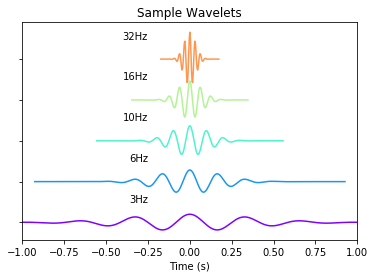

In [54]:
fig, ax = plt.subplots()
wavelet_freqs=  [3, 6, 10, 16, 32]
cmap = plt.cm.rainbow
for ii, freq in enumerate(wavelet_freqs):
    wavelet = mne.time_frequency.morlet(ecog.info['sfreq'], [freq])[0]
    time = np.arange(len(wavelet)) / float(ecog.info['sfreq'])
    time -= time[len(time) // 2]
    color = cmap(float(ii) / len(wavelet_freqs))
    ax.plot(time, wavelet + .5 * ii, c=color)
    ax.text(-.25, .5 * ii + .25, '{}Hz'.format(freq), horizontalalignment='right')
    ax.set_xlim([-1, 1])
_ = plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xlabel('Time (s)')
ax.set_title('Sample Wavelets')

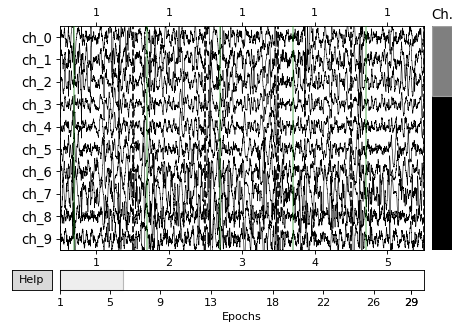

In [55]:
_ = ecog.plot(scalings='auto', n_epochs=5, n_channels=10)

In [59]:
import xarray as xr
def epochs_to_dataarray(epochs):
    """A simple function to convert an Epochs object to DataArray"""
    da = xr.DataArray(
    epochs._data,
    dims=['epoch', 'channel', 'time'],
    coords={
        'time': ecog.times,
        'channel': ecog.ch_names,
        'epoch': range(ecog._data.shape[0])
    },
    name='Sample dataset',
    attrs=dict(ecog.info)
    )
    return da

In [66]:
da = epochs_to_dataarray(ecog)
da

<xarray.DataArray 'Sample dataset' (epoch: 29, channel: 32, time: 2250)>
array([[[-118.10999298, -121.30046844, -117.64116669, ...,
           20.78869057,   11.38018703,    8.12319088],
        [-126.95540619, -120.84265137, -105.75999451, ...,
           25.57149315,   28.6223793 ,   24.82316971],
        [ -28.1061306 ,  -16.39686775,  -21.64873505, ...,
          -31.78049469,  -24.28160286,  -25.21776772],
        ...,
        [  18.55451965,   22.87419701,   25.66038895, ...,
           25.84903336,   19.71798515,   14.92882633],
        [ -44.79590607,  -49.5848465 ,  -52.08906555, ...,
          -48.92469025,  -54.11177826,  -60.23026276],
        [-105.09076691, -108.88887024, -113.57571411, ...,
           -3.28264022,    5.5660615 ,   13.18798733]],

       [[  20.84839821,   18.30262566,   20.12442017, ...,
          -19.40711594,  -18.51371574,  -20.21596718],
        [  18.0386982 ,    5.35804272,   -6.45382166, ...,
          -42.1801033 ,  -44.59093857,  -47.80654144],
        [  76.62892914,   73.66176605,   64.21563721, ...,
          -12.31007576,  -21.26686478,  -26.83379555],
        ...,
        [  58.06867599,   53.49727631,   51.89107895, ...,
           42.84626007,   52.36317062,   55.75439453],
        [ -24.79452324,  -18.58691406,   -8.12459183, ...,
          -45.95447159,  -42.66623306,  -41.06335449],
        [-110.1750946 , -101.40830994,  -88.24209595, ...,
          -26.7741375 ,  -32.31249619,  -37.07465744]],

       [[  44.85819626,   57.10462952,   68.87900543, ...,
           13.73396015,   28.33650208,   40.76254654],
        [  10.10721684,   19.94246101,   31.81379509, ...,
          120.01114655,  119.50100708,  128.0358429 ],
        [ -96.35434723,  -89.9883194 ,  -72.41400909, ...,
          140.28143311,  131.52635193,  133.30158997],
        ...,
        [   1.81244755,   -1.55214143,   -2.54425907, ...,
          -30.9526062 ,  -31.50832367,  -32.25312042],
        [  44.95462799,   38.7992363 ,   33.4192009 , ...,
           64.5262146 ,   62.74245834,   61.11261368],
        [ -37.66891861,  -37.9514122 ,  -40.97248077, ...,
           61.204319  ,   58.57411194,   56.27007675]],

       ...,

       [[  88.75709534,   83.42398071,   76.10377502, ...,
          -23.7650528 ,  -23.43914986,  -19.55894852],
        [  63.89505005,   63.79450226,   61.43893433, ...,
          -54.35200119,  -59.907547  ,  -69.36830139],
        [  39.31270599,   46.15828705,   51.12403107, ...,
          -30.19447899,  -27.1382637 ,  -19.75760651],
        ...,
        [  -2.09485602,  -13.05238819,  -19.73264503, ...,
          150.31195068,  129.28895569,  114.28322601],
        [-142.40054321, -142.72599792, -140.20773315, ...,
           90.81705475,   82.73035431,   77.06429291],
        [-161.34713745, -160.04364014, -151.092453  , ...,
          238.87109375,  230.41633606,  222.64045715]],

       [[  67.85353088,   72.97834778,   70.99682617, ...,
           99.13801575,   95.14775085,   86.59616089],
        [ 169.86994934,  172.12055969,  173.22143555, ...,
          132.95147705,  135.66346741,  141.64862061],
        [  80.4973526 ,   77.63601685,   73.43898773, ...,
           91.37036896,   84.76886749,   82.48825836],
        ...,
        [ -13.24606895,   -8.65564728,    6.53395557, ...,
         -105.62326813, -104.58720398, -107.99065399],
        [  22.20972443,   49.33536148,   85.349823  , ...,
         -103.54721069, -102.84375   , -104.26371002],
        [ -33.03855133,   -9.5574255 ,   10.97984695, ...,
         -148.20103455, -148.95999146, -154.4241333 ]],

       [[ -98.52385712,  -99.22042847,  -99.56749725, ...,
           49.72173309,   41.6667099 ,   31.01161194],
        [ -70.90259552,  -66.83739471,  -68.66448975, ...,
           35.73180008,   33.55708694,   28.1260643 ],
        [ -29.78354645,  -34.5358963 ,  -40.23687363, ...,
          -39.39603043,  -42.75005341,  -50.70994186],
        ...,
        [ 110.57292175,  103.35498047,   95.09171295, ...,
     

In [67]:
da = da.sel(time=slice(-1, 3))

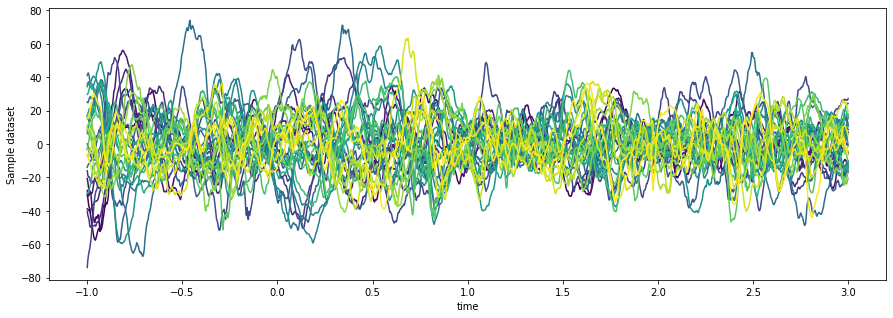

In [68]:
fig, ax = plt.subplots(figsize=(15, 5))
n_channels = da['channel'].shape[0]
ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, n_channels)))
da.mean(dim='epoch').plot.line(x='time', hue='channel')
ax.get_legend().remove()

In [69]:
prebaseline_mean = da.where(da.time < 0).mean(dim='time')
da_demeaned = da - prebaseline_mean

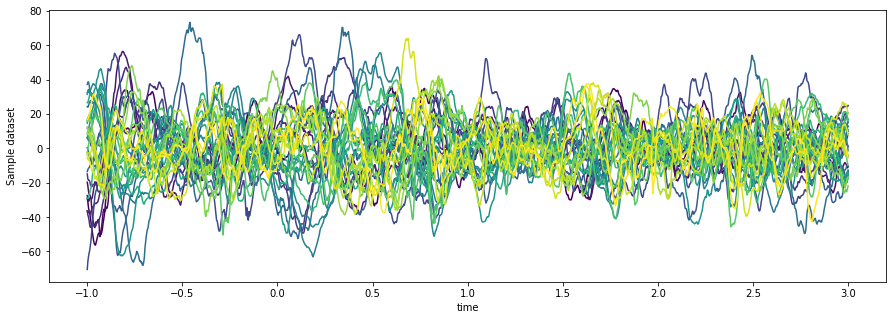

In [70]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, da['channel'].shape[0])))
da_demeaned.mean(dim='epoch').plot.line(x='time', hue='channel')
ax.get_legend().remove()

In [71]:
flow = 80
fhigh = 140
da_lowpass = xr.apply_ufunc(
    mne.filter.filter_data, da,
   kwargs=dict(
       sfreq=da.sfreq,
       l_freq=flow,
       h_freq=fhigh,
   )
)

Setting up band-pass filter from 80 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 145.00 Hz)
- Filter length: 99 samples (0.330 sec)



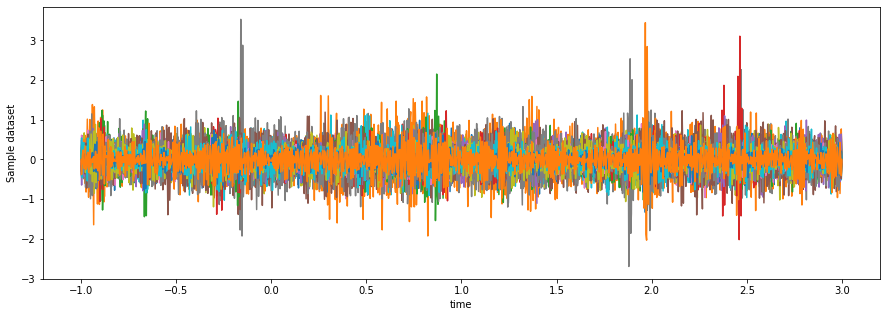

In [72]:
fig, ax = plt.subplots(figsize=(15, 5))
da_lowpass.mean(dim='epoch').plot.line(x='time')
ax.get_legend().remove()

In [73]:
def hilbert_2d(array):
    """Perform a Hilbert transforms on an (n_channels, n_times) array."""
    for ii, channel in enumerate(array):
        array[ii] = mne.filter._my_hilbert(channel, envelope=True)
    return array

da_hf_power = da_lowpass.groupby(da.coords['epoch']).apply(hilbert_2d)

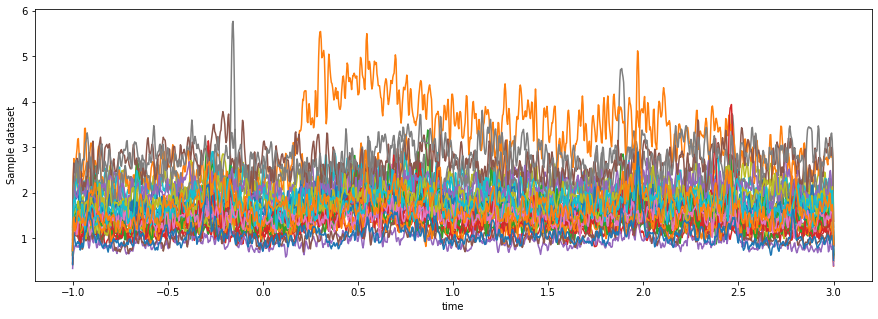

In [74]:
fig, ax = plt.subplots(figsize=(15, 5))
da_hf_power.mean(dim='epoch').plot.line(x='time', hue='channel')
ax.get_legend().remove()

In [82]:
frequencies = [2**ii for ii in np.arange(2, 9, .5)]
tfr = mne.time_frequency.tfr_array_morlet(
    da,
    sfreq=da.sfreq,
    freqs=frequencies,
#    n_cycles=4,
)
# Take the absolute value to throw out the non-real parts of the numbers
tfr = np.abs(tfr)
tfr[:2, :2, :2, :2]

ValueError: Cannot compute freq above Nyquist freq of the data (150.0 Hz), got 362.0 Hz

In [79]:
da_tfr = (da
    .expand_dims(frequency=frequencies)
    .transpose('epoch', 'channel', 'frequency', 'time')
    .copy(data=np.log(tfr))
)

NameError: name 'tfr' is not defined

In [ ]:
#!pip install vaex
import vaex
#import scipy
v=vaex.from_arrays(a=X_rt.transpose(), b=X_mz1.transpose(), c=X_int.transpose())
#v = v.count(binby=["a", "b", "c"])
# smooth it for visual pleasure
#v = scipy.ndimage.gaussian_filter(v,1)
v#.shape
v=v.values

In [ ]:
#!pip install ipyvolume
import pylab
import scipy.optimize as op
import emcee
import numpy as np
import vaex
import scipy.ndimage
import ipyvolume

ds = vaex.from_arrays(a=samples[...,0].copy(), b=samples[...,1].copy(), c=samples[...,2].copy())
# get 2d histogram
v = ds.count(binby=["a", "b", "c"], shape=64)
# smooth it for visual pleasure
v = scipy.ndimage.gaussian_filter(v, 2)

ipyvolume.quickvolshow(v, lighting=True)


In [ ]:
#https://github.com/llSourcell/Gaussian_Mixture_Models/blob/master/intro_to_gmm_%26_em.ipynb
class Gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def pdf(self, datum):
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [ ]:
best_single = Gaussian(np.mean(X_mz1), np.std(X_mz1))
print('Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))

In [ ]:
from scipy import stats
import seaborn as sns
sns.set_style("white")
x = np.linspace(-6, 8, 200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(X_mz1, bins=100, kde=False, norm_hist=True)
plt.plot(x, g_single, label='PDF')
plt.legend()

In [ ]:
data=X_mz1
from math import sqrt, log, exp, pi
from random import uniform
class GaussianMixture:
    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.mix = mix
    def Estep(self):
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield (wp1, wp2)
    def Mstep(self, weights):
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)
    def iterate(self, N=1, verbose=False):
    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)
    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

In [ ]:
# Check out the fitting process
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

In [ ]:
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')

In [ ]:
#from  rulsif import RULSIF
#from cycler import cycler
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import backend

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend
num_outputs=1000
model = Sequential()
#model.add(GaussianNoise(STD_DEV, input_shape=(MAX_WORDS, vectors.dim)))
#model.add(Bidirectional(LSTM(HIDDEN_UNITS, activation='tanh'), merge_mode='concat'))
#model.add(Dropout(DROPOUT_RATIO))
model.add(Dense(num_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer="Adam",metrics=['categorical_accuracy'])

In [ ]:
import keras
base_model=keras.applications.xception.Xception(include_top=True, 
                                                weights='imagenet', 
                                                input_tensor=None, 
                                                input_shape=None, 
                                                pooling=None, 
                                                classes=1000)
x=base_model.output
#x=GlobalAveragePooling4D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(2,activation='softmax')(x)

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)

In [ ]:
for layer in model.layers[:20]:    layer.trainable=False
for layer in model.layers[20:]:    layer.trainable=True

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory('./subCellular',
                                                  target_size=(299,299),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical', 
                                                  shuffle=True)
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,epochs=2)

In [ ]:
model.save('modelMGF.h5')    
!bzip2 'modelMGF.h5'

In [ ]:
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 16} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [ ]:
import pandas as pd
# import formatter as fm
df = pd.read_csv('Groups.txt',sep='\t')
df.head()

In [ ]:
#check also https://github.com/kusterlab/prosit/blob/master/prosit/prediction.py

In [ ]:
!mkdir  ~/.kaggle
!cp $PWD/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -lthr ~/.kaggle/

In [ ]:
#!$HOME/.local/bin/kaggle datasets download -d piotrgrabo/breastcancerproteomes --force
!$HOME/.local/bin/kaggle competitions download -c human-protein-atlas-image-classification

In [ ]:
!find $HOME -iname train

In [ ]:
!pip install -U -q PyDrive --user
!pip install -U -q google.colab --user

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

In [ ]:
!ls -ltrh

In [ ]:
outvec=[1 if 'positive' in i.parts[-2] else 0 for i in trainlist]
outvec

In [ ]:
outvecclip=outvec[0:99]

In [ ]:
(outvecclip)

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(MGF, binary_labels, test_size = .2)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=71, shuffle=True, random_state=42)
batches = [train for test, train  in kf.split(X_train, y_train)]
batches[0].shape

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
test_batches = [t_batch for _, t_batch  in kf.split(X_test, y_test)]
np.histogram(test_batches[9])

In [ ]:
X_train.shape,X_test.shape

In [ ]:
predictions = [result for p in pred for result in p ]
predictions

In [ ]:
from  sklearn.metrics import accuracy_score,log_loss #ytrue ypred
log_loss(y_test, [[p[0],1-p[0]] for p in predictions])

In [ ]:
np.round([p[0] for p in predictions])

In [ ]:
# Compute confusion matrix
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in predictions]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
import tensorflow as tf
print(tf.__version__)
import datetime
print(datetime.datetime.now())
tf.keras.backend.clear_session()
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print("Eager:",tf.executing_eagerly())
print("GPU:",tf.test.is_gpu_available())#:with tf.device("/gpu:0"):
#tf.keras.backend.clear_session()

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir="/mnt/promec-ns9036k/.tools/guiding-cow-tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train,
          y=y_train,
          epochs=5,
          validation_data=(x_test, y_test),
          callbacks=[tensorboard_callback])

<a href="https://colab.research.google.com/github/animesh/notebooks/blob/master/tfMGF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
*peptide spectra predictor*
- [Novo](https://github.com/nh2tran/DeepNovo)
- [Post](https://github.com/semiller10/postnovo)